## Team Name: Linearity
Mohammad Savarmand and Ruth Ann Phillippi\
(7 Sections)

# Section 1: Load the Enviornment

In [1]:
# install.packages("tictoc")
# install.packages("caTools")
# install.packages("caret")
# install.packages("reshape2")
# install.packages("plyr")
# install.packages("readr")

In [2]:
library(tidyverse)# To use dplyr/read_csv/tibbles etc
library(caret)    # Useful statistical functions
library(caTools)  # training/testing data
library(tictoc)   # To see the length of time for code to run
library(plyr)     # Reading data
library(readr)    # Reading data
library(reshape2) #For EDA correlation heatmap

Warning message:
"package 'tidyverse' was built under R version 4.2.2"
── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
Warning message:
"package 'ggplot2' was built under R version 4.2.2"
Warning message:
"package 'readr' was built under R version 4.2.2"
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 4.2.2"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'caTools' was built under R version 4.2.2"
Warning message:
"package 'tictoc' was built under R ver

# Section 2: Import the Data

In [3]:
tic()
set.seed(123)
setwd("C:\\Users\\Monke\\My Tresors\\School\\Fall 2022\\CS 636\\Final")

mydir = "Dataset"
myfiles = list.files(path=mydir, pattern="*.csv", full.names=TRUE)
myfiles

all <- llply(myfiles, read_csv)
toc()

[1] "Dataset/item_categories.csv"   "Dataset/items.csv"            
[3] "Dataset/sales_train.csv"       "Dataset/sample_submission.csv"
[5] "Dataset/shops.csv"             "Dataset/test.csv"

Rows: 84 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): item_category_name
dbl (1): item_category_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 22170 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): item_name
dbl (2): item_id, item_category_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2935849 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): date
dbl (5): date_block_num, shop_id, item_id, item_price, item_cnt_day

ℹ Use `spec()` to retri

1.59 sec elapsed


# Section 3: Data Preperation </b>

The code below helped us understand the dataset we are reading.

In [4]:
mapply(function(x){sum(is.na(x))},all)
mapply(function(x){sum(is.null(x))},all)
lapply(all, dim)
lapply(all, names)

[1] 0 0 0 0 0 0

[1] 0 0 0 0 0 0

[[1]]
[1] 84  2

[[2]]
[1] 22170     3

[[3]]
[1] 2935849       6

[[4]]
[1] 214200      2

[[5]]
[1] 60  2

[[6]]
[1] 214200      3

[[1]]
[1] "item_category_name" "item_category_id"  

[[2]]
[1] "item_name"        "item_id"          "item_category_id"

[[3]]
[1] "date"           "date_block_num" "shop_id"        "item_id"       
[5] "item_price"     "item_cnt_day"  

[[4]]
[1] "ID"             "item_cnt_month"

[[5]]
[1] "shop_name" "shop_id"  

[[6]]
[1] "ID"      "shop_id" "item_id"

### Creation of Working Dataframe
In the following line of code we combined the sales_train (ST) data with the test.csv (test) data. "sales_train.csv" and "test.csv" both had two keys which meant we had to be extra careful when joining these two datasets.

In [5]:
tic()
# Make "date" a Date type instead of Character
all[[3]] <- all[[3]] %>%
  mutate(date = as.Date(all[[3]]["date"][[1]], "%d.%m.%Y"))

df3 <- all[[3]]

# 3 + 6
df36 <- full_join(df3, all[[6]], c("item_id","shop_id"))
toc()

3.09 sec elapsed


### Accounting for Unavailable Data
When we joined together the sales_train  dataframe with the test dataframe using "full_join", we experienced many issues with an excessive number of NAs. We later found that the NAs appeared when a specific store never sold a specific item. For example, shop #5 (shop_id == 5) never once, from date to date, sold item #5320 (item_id == 5320). This means that when we joined the sales training data with the testing dataset based on the ID number, there was nothing with which we could join the sales data to test data. Our code below helped us find just how many NAs were present in our data.

In [6]:
head(df36 %>% filter(is.na(ID)))
head(df36 %>% filter(is.na(date)))

date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2013-01-03,0,25,2552,899.00,1,NA
2013-01-05,0,25,2552,899.00,-1,NA
2013-01-06,0,25,2554,1709.05,1,NA
2013-01-15,0,25,2555,1099.00,1,NA
2013-01-10,0,25,2564,349.00,1,NA
2013-01-02,0,25,2565,549.00,1,NA


date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,NA,5,5320,NA,NA,1
NA,NA,5,5268,NA,NA,4
NA,NA,5,5003,NA,NA,9
NA,NA,5,4874,NA,NA,16
NA,NA,5,5002,NA,NA,21
NA,NA,5,5907,NA,NA,25


### Strategy to fill NAs
The bottom cells with dataframes variations of "df36" aim to fix this problem in our data set. Initially we wanted to remove all NAs, but we would lose too much data. The top cell show how our dataset is filled with NAs in different spots. When joining two datasets with inconsitencies with "full_join", more rows are created than there should be. The inconsistencies of "sailes_train.csv" simply make rows of NA ID. Similarly with the inconsitencies of "test.csv", full_join makes rows of NAs for c(data, date_block_num, item_price, item_cnt_day).

Since the Kaggle output requires two columns (ID, and item_cnt_month), we decided to remove all NA IDs; this lost some information, but still retain all the IDs we need which is 214200 rows of unique IDs.

Since we took care of the NA IDs by filtering them out, we needed a more careful way to fill the other NAs. We chose to create a random uniformly distrubted set of numbers within each feature's respective range for c(date_block_num, and date) because we have no information about the dates of NA.

For item_cnt_date, we chose to fill the NAs with zero because we assumed since there are NAs, this means there were no sales which should mean item_cnt_day is 0.

Finally for item_price, we chose to group_by item_id and calculate the average prices of existing products. Then we joined the new dataframe by item_id and replaced the NAs with the means.

In [7]:
# Count how many unique dates are present in our dataset
df_date_id_group_dim <- dim(
  df36 %>%
  filter(!is.na(date)) %>%
  arrange(date) %>%
  dplyr::count(date)
)
df_date_id_group_dim

# Output will be the number of rows of data without any missing values (NA)
df_date_id_dim <- dim(
  df36 %>%
  filter(!is.na(date)) %>%
  arrange(date)
)
df_date_id_dim

# Output will be the number of rows in the date column with a missing value (NA)
df_date_id_na_dim <- dim(
  df36 %>%
  filter(is.na(date)) %>%
  arrange(date)
)
df_date_id_na_dim

[1] 1034    2

[1] 2935849       7

[1] 102796      7

In [8]:
# New date_block_new numbers for the NA values
new_date_block_num <- data.frame(round(runif(n=df_date_id_group_dim[1], min=0, max=33), 0))
colnames(new_date_block_num) <- c("new_date_block_num")
# head(new_date_block_num)

df_date_id <- df36 %>%
  filter(!is.na(date)) %>%
  dplyr::count(date) %>%
  arrange(date) %>%
  mutate(date_id = seq(1,df_date_id_group_dim[1])) %>%
  select(-n)
  # head(df_date_id)
  # dim(df_date_id)

df36_1 <- full_join(df36, df_date_id, c("date")) %>%
  select(-date)
  # head(df36_1)

# New date_id numbers for the NA values (should be 102831)
new_date_id <- data.frame(round(runif(n=df_date_id_na_dim[1], min=1, max=df_date_id_group_dim[1]), 0))
colnames(new_date_id) <- c("new_date_id")
# head(new_date_id %>% arrange(new_date_id) %>% count(new_date_id))
# dim(new_date_id)

# head(new_date_id)

In [9]:
df36_2 <- df36_1 %>%
    # Finding all rows where ID is not NA
    filter(!is.na(ID)) %>%
    # Giving random uniform numbers to the NAs in date_block_num within the range 0-33
    mutate(date_block_num = ifelse(is.na(date_block_num), new_date_block_num$new_date_block_num, date_block_num)) %>%
    # Giving random uniform numbers to the NAs in date_id within the range 1-1034
    mutate(date_id = ifelse(is.na(date_id), new_date_id$new_date_id, date_id)) %>%
    # Giving zeroes to item_cnt_day since we are assuming NA means no selling occured
    mutate(item_cnt_day = ifelse(is.na(item_cnt_day), 0, item_cnt_day))

In [10]:
dim(df36_2 %>% dplyr::count(ID))
names(df36_2)

[1] 214200      2

[1] "date_block_num" "shop_id"        "item_id"        "item_price"    
[5] "item_cnt_day"   "ID"             "date_id"

In [11]:
# Getting the means for each item_id
df36_2_mean_item_id <- df36_2 %>%
  dplyr::filter(!is.na(item_price)) %>%
  dplyr::arrange(item_id) %>%
  dplyr::group_by(item_id) %>%
  dplyr::summarise(mean = mean(item_price))

# dim(df36_2_mean_item_id)
# head(df36_2_mean_item_id)

# Getting the correct dimensions for each mean by joining it to df36_2 when
# item_price is NA
df36_2_item_joined <- df36_2 %>%
  filter(is.na(item_price)) %>%
  arrange(item_id) %>%
  inner_join(df36_2_mean_item_id, by = "item_id")


# dim(df36_2_item_joined)
# head(df36_2_item_joined) 

In [12]:
df36_3 <-   df36_2 %>%
    arrange(item_id) %>%
    # Giving mean item_price group_by to item_id to NAs 
    mutate(item_price = ifelse(is.na(item_price), df36_2_item_joined$mean, item_price))
head(df36_3)
dim(df36_3 %>% dplyr::count(ID))

date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,date_id
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,30,399.0000,1,109687,59
1,50,30,399.0000,1,109687,57
1,50,30,399.0000,1,109687,43
1,50,30,399.0000,2,109687,45
1,50,30,399.0000,3,109687,46
1,50,30,385.6667,3,109687,47


[1] 214200      2

In [13]:
# 3 + 6 + 5
df365 <- left_join(df36_3, all[[5]], by = "shop_id")

# 3 + 6 + 5 + 4
df3654 <- left_join(df365, all[[4]], by = "ID")

# 3 + 6 + 5 + 4 + 2
df36542 <- left_join(df3654, all[[2]], by = "item_id")

# 3 + 6 + 5 + 4 + 2 + 1
df365421 <- left_join(df36542, all[[1]], by = "item_category_id")

# 3 + 6 + 5 + 4 + 2 + 1
# into a less annoying name
df <-df365421
#head(df)
dim(df)
dim(df %>% dplyr::count(ID))
sum(is.na(df))

[1] 1327235      12

[1] 214200      2

[1] 0

# Section 4: Exploratory Data Analysis

This section is mainly to show the graphs that guided us to use our final model.

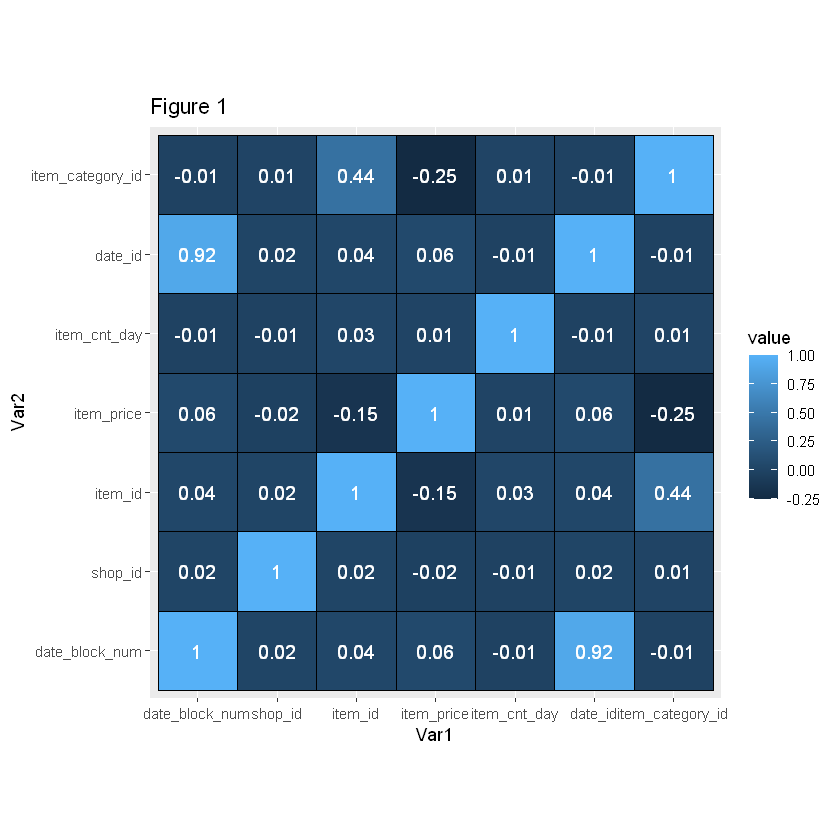

In [14]:
df_num <- df %>%
  select(where(is.numeric),-ID,-item_cnt_month)

# creating correlation matrix
corr_mat <- round(cor(df_num),2)
 
# reduce the size of correlation matrix
melted_corr_mat <- melt(corr_mat)
# head(melted_corr_mat)
 
# plotting the correlation heatmap
ggplot(data = melted_corr_mat, aes(x=Var1, y=Var2,
                                   fill=value)) +
geom_tile(color = "black")+
geom_text(aes(label = value), color = "white", size = 4) +
coord_fixed() +
ggtitle("Figure 1")

**Figure 1** dipicts a coorelation matrix with all of the variables remaining after we prepared our data in **Section #3**.

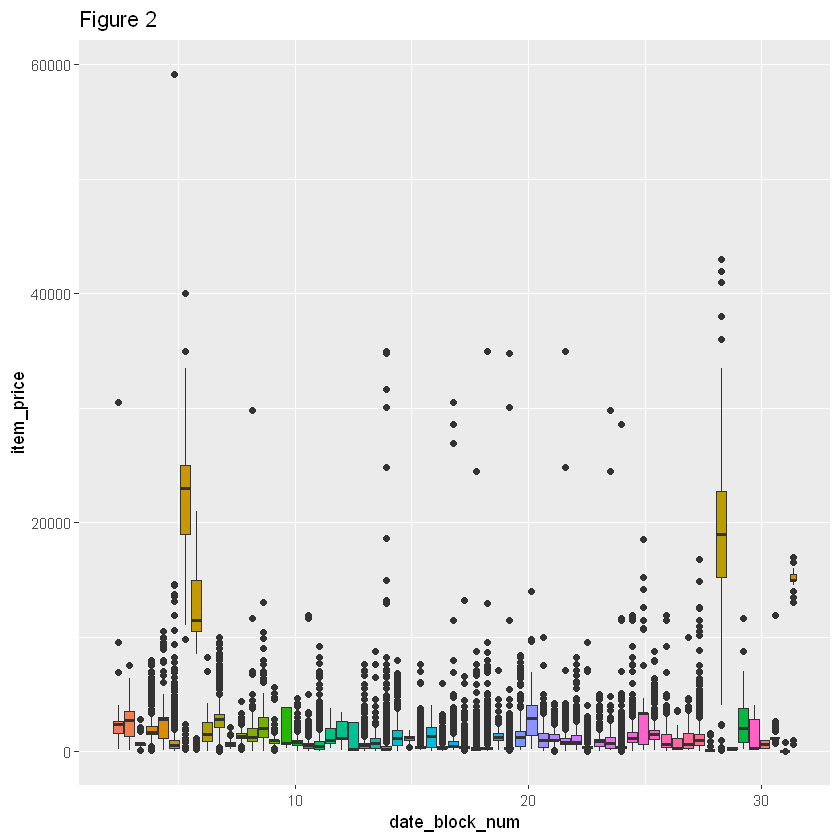

In [15]:
d <- ggplot(df, aes(x = date_block_num, y = item_price))

d +
  geom_boxplot(aes(fill= item_category_name ))+
  theme(legend.position = "none")+
  ggtitle("Figure 2")


**Figure 2** shows how poor the data is in terms of homoscedasticity. It is important to have good homoscedasticity in graphs in order to better visualize the data. We will mend this in the next figure.

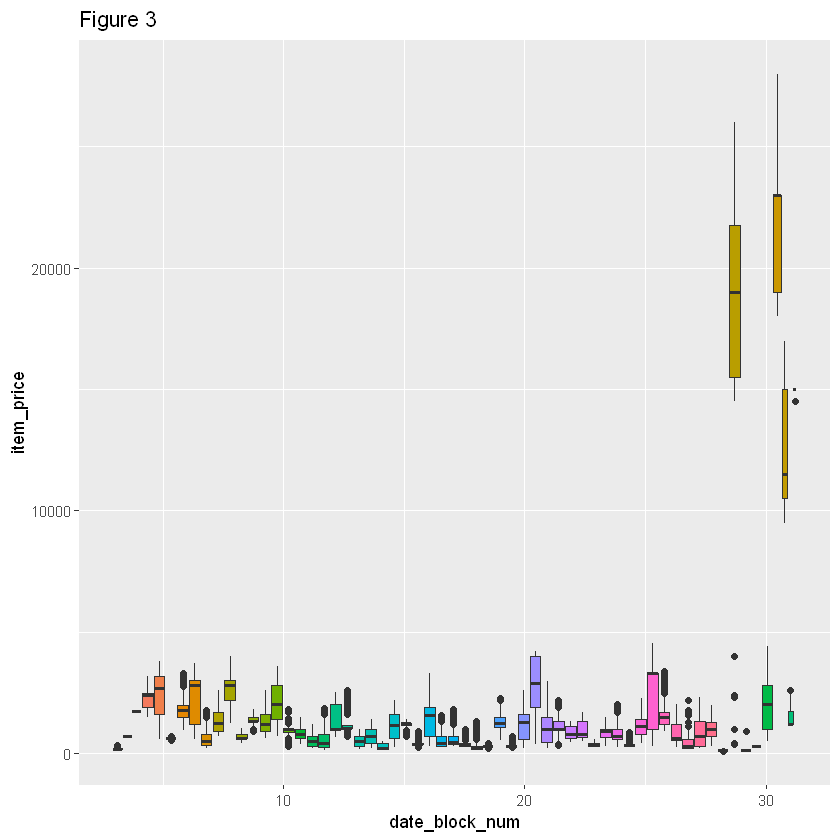

In [16]:
df_filter <- df %>%
 group_by(item_category_id) %>%
 filter(item_price > quantile(item_price, 0.1), 
         item_price < quantile(item_price, 0.90))

d <- ggplot(df_filter, aes(x = date_block_num, y = item_price))

d +
  geom_boxplot(aes(fill= item_category_name ))+
  theme(legend.position = "none") +
  ggtitle("Figure 3")

**Figure 3** showcases the fluxuation of the item-prices color-coded by the item category.

In [17]:
dim(df)
dim(df_filter)
dim(df_filter)[1] / dim(df)[1]
dim(df_filter %>% dplyr::count(ID))
dim(df %>% dplyr::count(ID))[1] - dim(df_filter %>% dplyr::count(ID))[1]

[1] 1327235      12

[1] 939561     12

[1] 0.7079085

[1] 145817      3

[1] 68383

By removing all points bellow the 10th percentile and all points above the 90th, the boxplot graph looks much better than it was before. We still retain 70% of our data which is enough to guess how the model will behave. Unfortuantely, we lose about 68k unique datapoints when filtering like this so unfortunately we have to keep all datapoints in our model.

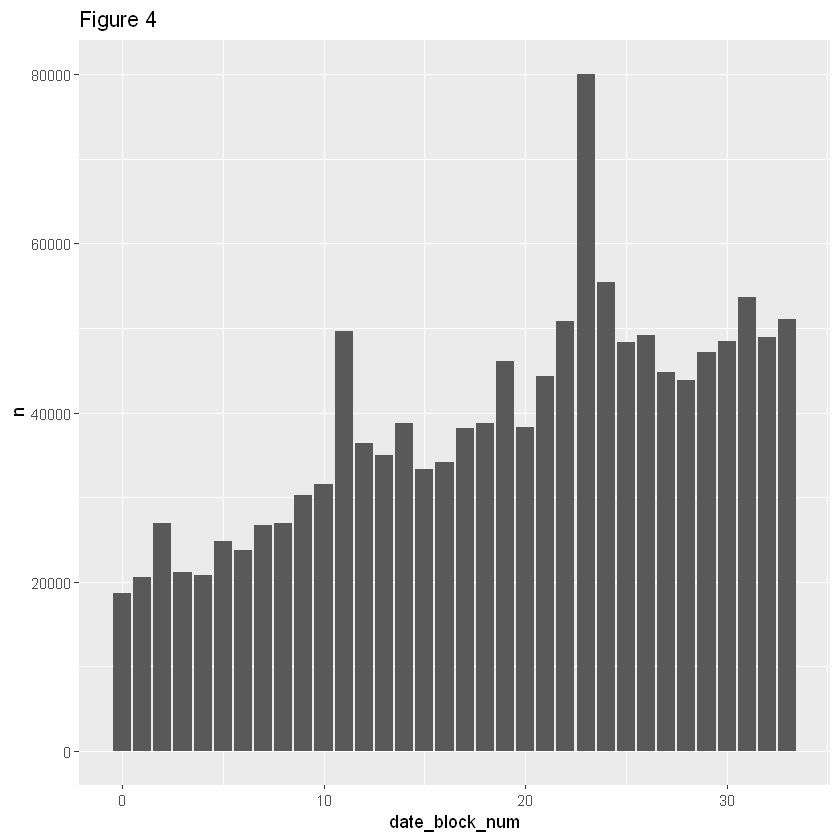

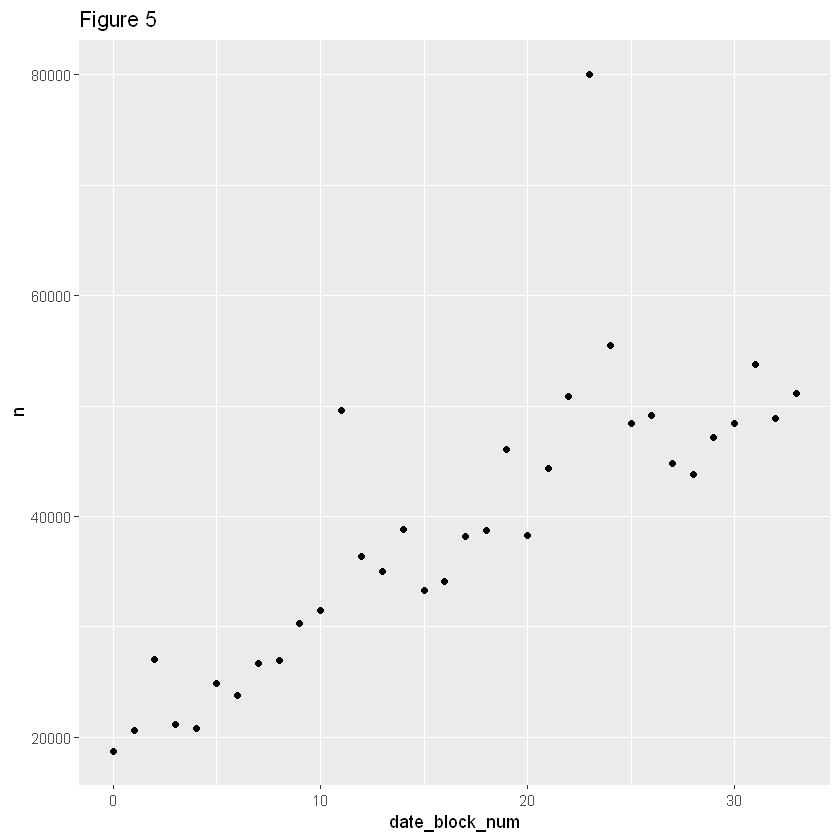

In [18]:
df_count_month <- df %>%
  dplyr::count(date_block_num)

g <- ggplot(df_count_month, aes(date_block_num, n))
g +
  geom_col() +
  ggtitle("Figure 4")

h <- ggplot(df_count_month, aes(date_block_num, n))
h +
  geom_point() +
  ggtitle("Figure 5")

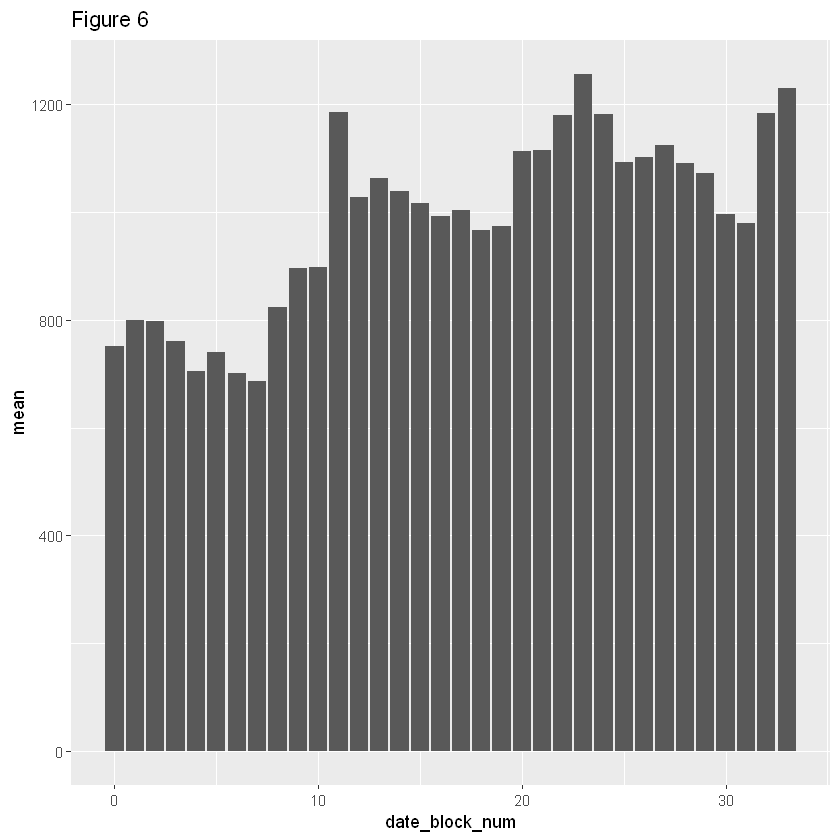

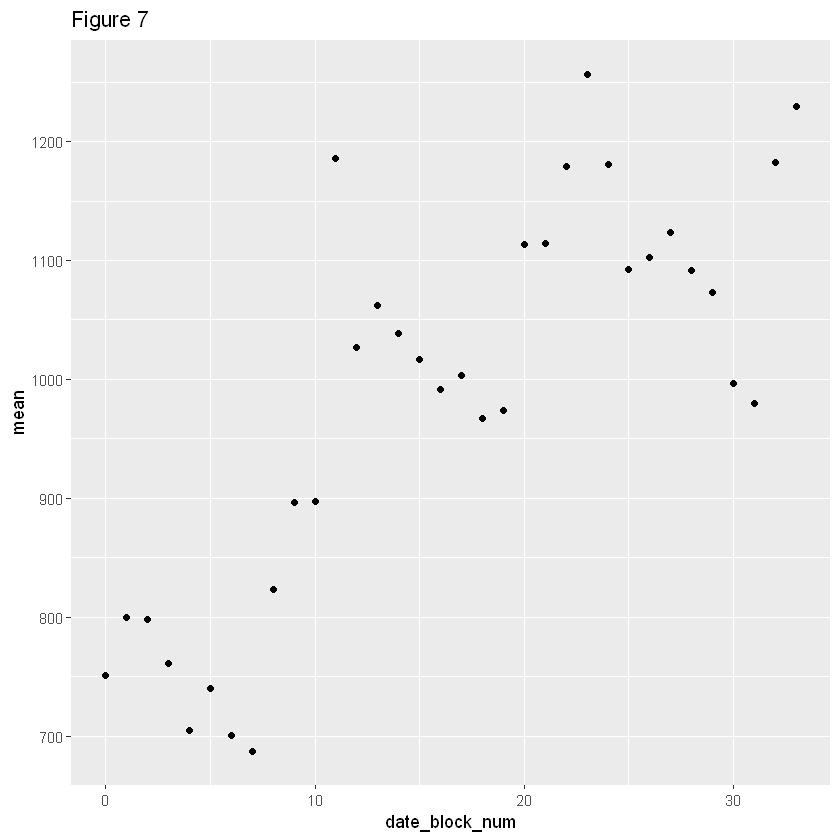

In [19]:
df_mean_month <- df %>%
 dplyr::group_by(date_block_num) %>%
 dplyr::summarise(mean = mean(item_price)) %>%
 dplyr::arrange(date_block_num)

g <- ggplot(df_mean_month, aes(date_block_num, mean))
g +
  geom_col() +
  ggtitle("Figure 6")

h <- ggplot(df_mean_month, aes(date_block_num, mean))
h +
  geom_point() +
  ggtitle("Figure 7")

# Section 5: Modeling

### Modeling Plan Part 1 of 2
We decided to use a linear regression model. Figure 6 and 7 gave us reason to believe a linear model was satisfactory for this prediction problem. The boxplot shows that some item categories were slightly above the mean prices of most of the other categories. We decided 3 outliter categories is not enough to destroy our linear regression model.

From the start we acknowledge our model is not going to be perfect for one key reason. The correct way to use linear regression with categorical data in R (if we are using lm() function) is to make them factors. If we fed the lm() function only dbl types when we know the "id" columns are categories, we are already making a mistake. Having said that, when we tried factoring all categorical columns, we experienced crashes so we only factored two of the columns. This will be mentioned again in the evaluation section.

The objective is to predict "item_cnt_day" and then group_by the IDs to obtain the item_cnt_month. This is a two step process where the first step is the most difficult.

In the first step, we decided to use two variable linear regression (because only two of our variables were continous) and multivariate linear regression. We also used a polynomial model, but since we had so many factors, attempts to 4th degree every variables ended up with a crash. Having said that, out of the three models we tested (2 var linear, mul var linear, semi polynomial), the multivariable linear model scored the highest R<sup>2</sup> and the lowest Root Mean Square Error (RMSE). 

Lower RMSE is better, higher R<sup>2</sup> is better, thus multivariate was chosen.

In [20]:
df_new <- df %>%
  dplyr::select(1:7,11) %>%
  dplyr::mutate(shop_id = as.factor(shop_id)) %>%
  # mutate(item_id = as.factor(item_id)) %>%
  # mutate(ID = as.factor(ID)) %>%
  dplyr::mutate(item_category_id = as.factor(item_category_id))

head(df_new)

date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,date_id,item_category_id
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,50,30,399.0000,1,109687,59,40
1,50,30,399.0000,1,109687,57,40
1,50,30,399.0000,1,109687,43,40
1,50,30,399.0000,2,109687,45,40
1,50,30,399.0000,3,109687,46,40
1,50,30,385.6667,3,109687,47,40


In [21]:
set.seed(123)
split = sample.split(df_new$item_cnt_day, SplitRatio = 0.8)
training_set = subset(df_new, split == TRUE)
test_set = subset(df_new, split == FALSE)

In [22]:
tic()
# 2 variable linear
one_lin = lm(formula = item_cnt_day ~ item_price + date_block_num,
               data = training_set)
# Make predictions
predictions_one_lin <- one_lin %>% predict(test_set)
# Model performance
data.frame(
  RMSE = RMSE(predictions_one_lin, test_set$item_cnt_day),
  R2 = R2(predictions_one_lin, test_set$item_cnt_day)
)
toc()

RMSE,R2
<dbl>,<dbl>
1.841489,0.0003148503


0.17 sec elapsed


In [23]:
tic()
# Multivariable linear THIS IS THE MODEL USED FOR OVERALL PREDICTIONS
mul_lin_main = lm(formula = item_cnt_day ~ .,
               data = training_set)
# Make predictions
predictions_mul_lin <- mul_lin_main %>% predict(test_set)
# Model performance
data.frame(
  RMSE = RMSE(predictions_mul_lin, test_set$item_cnt_day),
  R2 = R2(predictions_mul_lin, test_set$item_cnt_day)
)
toc()

RMSE,R2
<dbl>,<dbl>
1.695315,0.1544404


12.21 sec elapsed


In [24]:
tic()
# polynomial linear, 1 x variable
pol_lin <- lm(item_cnt_day ~ polym(date_block_num, degree=4, raw=TRUE), data = training_set)

# Make predictions
predictions_pol1 <- pol_lin %>% predict(test_set)
# Model performance
data.frame(
  RMSE = RMSE(predictions_pol1, test_set$item_cnt_day),
  R2 = R2(predictions_pol1, test_set$item_cnt_day)
)
toc()

RMSE,R2
<dbl>,<dbl>
1.841019,0.000807269


0.42 sec elapsed


In [25]:
# # polynomial linear, all x variables
# mul_pol_lin <- lm(item_cnt_day ~ polym(date_block_num, item_id, item_price, shop_id, item_category_id, degree=4, raw=TRUE), data = training_set)

# # Make predictions
# predictions_polall <- mul_pol_lin %>% predict(test_set)
# # Model performance
# data.frame(
#   RMSE = RMSE(predictions_polall, test_set$item_cnt_day),
#   R2 = R2(predictions_polall, test_set$item_cnt_day)
# )

model "mul_pol_lin" crashes the instance

In [26]:
tic()
# polynomial linear, all x variables. date_block_num, item_price at 4th degree, the rest at 1st
mul_pol_lin2 <- lm(item_cnt_day ~ polym(date_block_num, item_price, degree=4, raw=TRUE) + item_id + shop_id + item_category_id, data = training_set)

# Make predictions
predictions_pol_some <- mul_pol_lin2 %>% predict(test_set)
# Model performance
data.frame(
  RMSE = RMSE(predictions_pol_some, test_set$item_cnt_day),
  R2 = R2(predictions_pol_some, test_set$item_cnt_day)
)
toc()

RMSE,R2
<dbl>,<dbl>
1.696681,0.1533337


15.17 sec elapsed


In [27]:
prediction_used <- data.frame(predictions_mul_lin)
colnames(prediction_used) <- c("prediction_used")
head(prediction_used)
head(test_set)

,prediction_used
,<dbl>
1,0.9370336
2,0.9368687
3,0.9367037
4,0.9366487
5,0.8786399
6,0.8782549


date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,date_id,item_category_id
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,50,30,399,2,109687,45,40
1,50,30,399,3,109687,48,40
1,50,30,399,1,109687,51,40
1,50,30,399,1,109687,52,40
1,52,30,399,2,124987,47,40
1,52,30,399,2,124987,54,40


### Modeling Plan Part 2 of 2
#### How good was our training_data vs our test_data?

After getting predicitions for item_cnt_day in the training_set, we wanted to see how much we deviated from the test_set.

Ideally we should create a prediction column and actual column to represent a y=x graph. Therefore, we chose to use a linear regression to give us the  R<sup>2</sup> and RMSE when all of our predictions were convereted into the form Kaggle wanted. The results were relatively good considering the assumptions we made in earlier sections.

RMSE of 2.537743

R<sup>2</sup> of 0.8585306

In [28]:
tic()
test_set_result <- test_set %>%
  cbind(prediction_used) %>%
  select(-c(1:4))
toc()

0.05 sec elapsed


In [29]:
head(test_set_result)
dim(test_set_result)

,item_cnt_day,ID,date_id,item_category_id,prediction_used
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,2,109687,45,40,0.9370336
2,3,109687,48,40,0.9368687
3,1,109687,51,40,0.9367037
4,1,109687,52,40,0.9366487
5,2,124987,47,40,0.8786399
6,2,124987,54,40,0.8782549


[1] 265434      5

In [30]:
df_ID_result <- test_set_result %>%
  dplyr::ungroup()%>%
  dplyr::group_by(ID) %>%
  dplyr::summarise(sum_pred = sum(prediction_used), sum_actual = sum(item_cnt_day)) %>%
  dplyr::arrange(ID)
head(df_ID_result)

ID,sum_pred,sum_actual
<dbl>,<dbl>,<dbl>
0,3.3189680,3
2,3.2151097,3
5,3.0256434,3
7,0.8654943,1
8,7.8235614,10
10,7.1919672,6


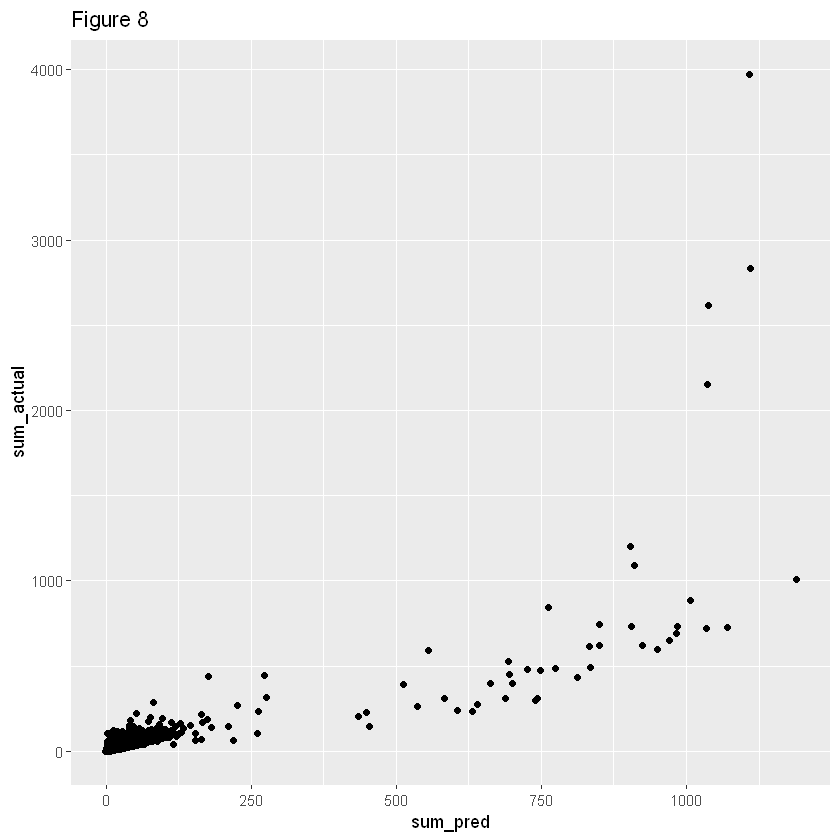

In [31]:
ggplot(df_ID_result) +
  geom_point(aes(sum_pred,sum_actual)) +
  ggtitle("Figure 8")

In [32]:
set.seed(123)
split = sample.split(df_ID_result$sum_actual, SplitRatio = 0.8)
training_set2 = subset(df_ID_result, split == TRUE)
test_set2 = subset(df_ID_result, split == FALSE)

In [33]:
# Multivariable linear For ACTUAL VS PRED
mul_lin = lm(formula = sum_actual ~ sum_pred,
               data = training_set2)
# Make predictions
predictions_one_lin <- mul_lin %>% predict(test_set2)
# Model performance
data.frame(
  RMSE = RMSE(predictions_one_lin, test_set2$sum_actual),
  R2 = R2(predictions_one_lin, test_set2$sum_actual)
)

RMSE,R2
<dbl>,<dbl>
2.537743,0.8585306


In [34]:
dim(df)
dim(df_new)

[1] 1327235      12

[1] 1327235       8

# Section 6: Submitting a final csv to Kaggle
Since we were instructed to complete this project as if we wanted to submit to Kaggle, the next cells will use our previous model which gave us a good prediction and predict using all the data in the dataset. Then we will again look at the graph of actual vs prediction.

In [35]:
prediction_final <- mul_lin_main %>% predict(df_new)

In [36]:
df_final <- df_new %>%
  cbind(prediction_final) %>%
  select(-c(1:4),-8) %>%
  arrange(ID)
#head(df_final)

In [37]:
#head(df_final %>% dplyr::count(ID))
dim(df_final %>% dplyr::count(ID))
distinct_ID <- df_final %>% dplyr::count(ID) %>% select(1)

[1] 214200      2

In [38]:
# verifying if ID is truly a sequence of numbers from 0 to 214199
sum(distinct_ID != data.frame(as.numeric(seq(0,214199))))

[1] 0

In [39]:
tic()
df_ID_result_final <- df_final %>%
  dplyr::group_by(ID) %>%
  dplyr::summarise(sum_pred = sum(prediction_final), sum_actual = sum(item_cnt_day)) %>%
  dplyr::arrange(ID)
toc()
#head(df_ID_result_final)

0.91 sec elapsed


11.47 sec elapsed


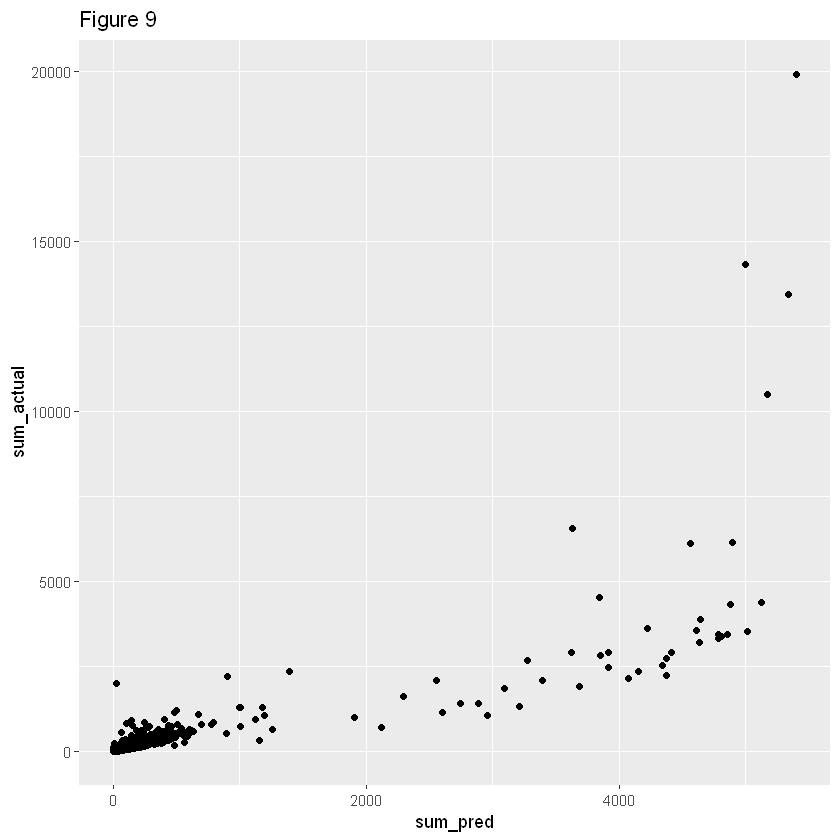

In [40]:
tic()
ggplot(df_ID_result_final) +
  geom_point(aes(sum_pred,sum_actual))+
  ggtitle("Figure 9")
toc()

In [41]:
#head(df_ID_result_final)

In [42]:
set.seed(123)
split = sample.split(df_ID_result_final$sum_actual, SplitRatio = 0.8)
training_set3 = subset(df_ID_result_final, split == TRUE)
test_set3 = subset(df_ID_result_final, split == FALSE)

In [43]:
# Multivariable linear For ACTUAL VS PRED
mul_lin = lm(formula = sum_actual ~ sum_pred,
               data = training_set3)
# Make predictions
predictions_one_lin_final <- mul_lin %>% predict(test_set3)
# Model performance
data.frame(
  RMSE = RMSE(predictions_one_lin_final, test_set3$sum_actual),
  R2 = R2(predictions_one_lin_final, test_set3$sum_actual)
)

RMSE,R2
<dbl>,<dbl>
7.64691,0.8733357


In [44]:
df_ID_result_final_submission <- df_ID_result_final %>%
  dplyr::select(1:2) %>%
  dplyr::rename(item_cnt_month = sum_pred)

In [45]:
head(df_ID_result_final_submission)

ID,item_cnt_month
<dbl>,<dbl>
0,14.4362634
1,0.8947801
2,9.6782207
3,0.9744340
4,1.4033332
5,11.3679233


In [46]:
# This dataframe scored a 66 on the Kaggle submissions
# write_csv(df_ID_result_final_submission,"df_submission.csv")

# Section 7: Evaluation

In general, our model was successful in predicitng the output. The model is definitely not the most optimized and there are some reasons for this:

Reason 1: There may be better methods of data preperation that we were not aware of when full_joining. Since we introduced random observations, we deliberatly made the data somewhat worse to be able to keep all of our unique IDs. Techniques like Synthetic Minority Oversampling Technique (SMOTE) on python may be able to fill in the blanks better than our current method, however this seemed to be an extremely advanced technique with assumptions we may not be aware of.

Reason 2: We know our model is slightly incorrect since we treated item_id and ID as continous variables. That is why we first used a 2 variable linear regression with only the continous variables, but the RMSE and  R<sup>2</sup> were significantly worse than the slightly wrong multivaraite model. In the future if we used one model for the continous variables and another for categorical, we could have ensembled them into one stronger model. Unfortunately this is too advanced for us currently.

In conclusion, our model was reasonable and the formatting of our "df_submission.csv" file was accepted in Kaggle and gave us a 66 score.